In [ ]:
import os
import pandas as pd

# Path definition of the news archives
path ='/content/drive/MyDrive/bbc-fulltext/bbc'

# List with the 5 categories
list_categories = os.listdir(path)

# Function to read files from each category and create dataframe
def create_dataframe(category_path, category):
    files = os.listdir(category_path)
    data = []
    for file in files:
        with open(os.path.join(category_path, file), 'r', encoding='utf-8') as f:
            content = f.read()
            data.append([file, content, category])
    return pd.DataFrame(data, columns=['File_Name', 'Content', 'Category'])

# Initialize an empty dataframe
df_final = pd.DataFrame(columns=['File_Name', 'Content', 'Category'])

# Iterate through categories, read files, and append to dataframe
for category in list_categories:
    category_path = os.path.join(path, category)
    df = create_dataframe(category_path, category)
    df_final = pd.concat([df_final, df], ignore_index=True)

# Add a new column with combined filename and category
df_final['Complete_Filename'] = df_final['File_Name'] + '-' + df_final['Category']

# Save dataset to CSV
df_final.to_csv('News_dataset.csv', encoding='utf-8', index=False)

In [ ]:
df_final

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import altair as alt
import pandas as pd

# Enable Altair to use Colab renderer
alt.renderers.enable('colab')

# Count the number of articles in each category
category_counts = df_final['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Create Altair chart
bars = alt.Chart(category_counts).mark_bar(size=50).encode(
    x=alt.X("Category"),
    y=alt.Y("Count:Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('Count:Q', title='Number of articles'), 'Category'],
    color='Category'
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='Count:Q'
)

chart = (bars + text).properties(
    height=300,
    width=700,
    title = "Number of articles in each category",
)

chart.interactive()


alt.LayerChart(...)

In [ ]:
df_final['News_length'] = df_final['Content'].str.len()

In [ ]:
df_final['id'] = 1
df2 = pd.DataFrame(df_final.groupby('Category').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300,
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

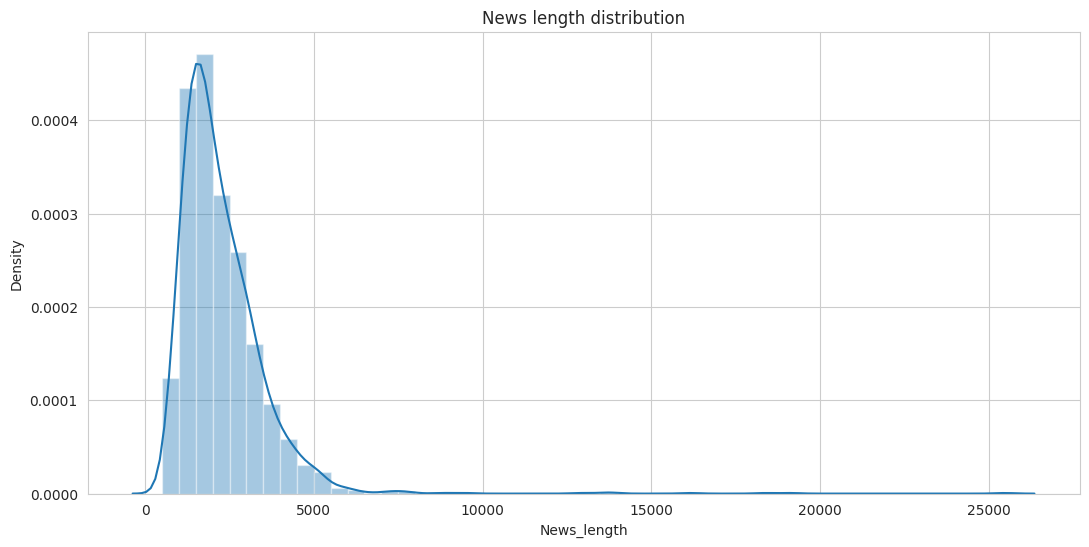

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_final['News_length']).set_title('News length distribution');

In [ ]:
df_final['News_length'].describe()

count     2225.000000
mean      2265.160449
std       1364.094764
min        503.000000
25%       1448.000000
50%       1967.000000
75%       2804.000000
max      25485.000000
Name: News_length, dtype: float64

In [ ]:
quantile_95 = df_final['News_length'].quantile(0.95)
df_95 = df_final[df_final['News_length'] < quantile_95]

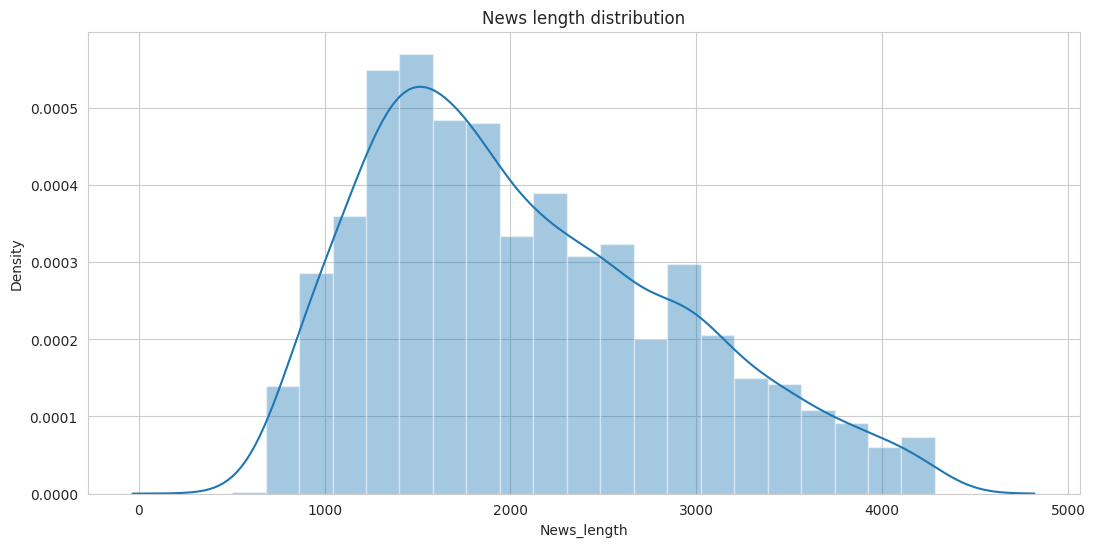

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length']).set_title('News length distribution');

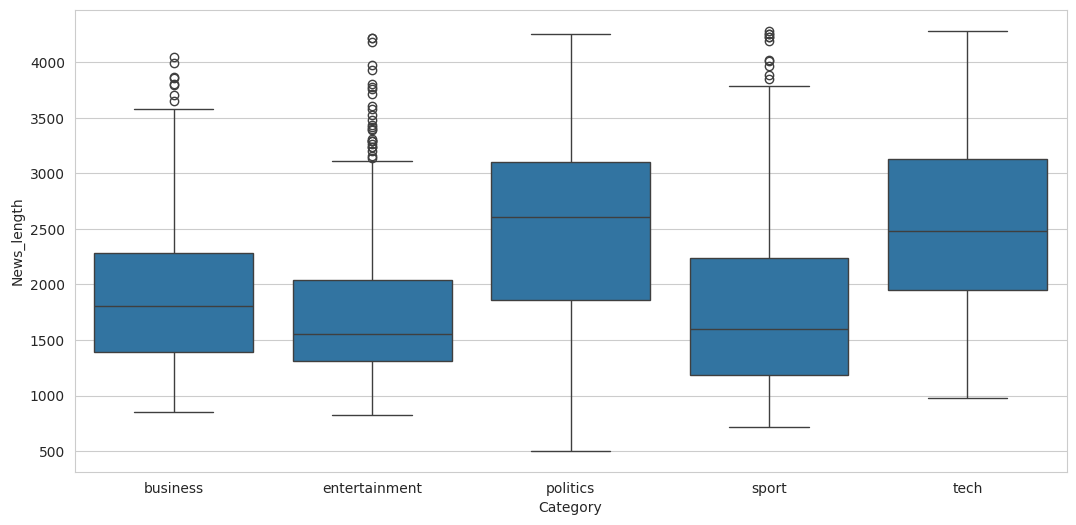

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

In [ ]:
with open('News_dataset.pickle', 'wb') as output:
    pickle.dump(df_final, output)

In [ ]:
from google.colab import files
files.download('News_dataset.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature Engineering


In [ ]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

path_df = "/content/News_dataset (1).pickle"

with open(path_df, 'rb') as data:
    df = pickle.load(data)

df.tail()

In [ ]:
df.loc[1]['Content']

'US trade gap hits record in 2004\n\nThe gap between US exports and imports hit an all-time high of $671.7bn (£484bn) in 2004, latest figures show.\n\nThe Commerce Department said the trade deficit for all of last year was 24.4% above the previous record - 2003\'s imbalance of $496.5bn. The deficit with China, up 30.5% at $162bn, was the largest ever recorded with a single country. However, on a monthly basis the US trade gap narrowed by 4.9% in December to £56.4bn. The US consumer\'s appetite for all things from oil to imported cars, and even wine and cheese, reached record levels last year and the figures are likely to spark fresh criticism of President Bush\'s economic policies.\n\nDemocrats claim the administration has not done enough to clamp down on unfair foreign trade practices. For example, they believe China\'s currency policy - which US manufacturers claim has undervalued the yuan by as much as 40% - has given China\'s rapidly expanding economy an unfair advantage against US

In [ ]:
# \r and \n
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

In [ ]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

In [ ]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
df

,File_Name,Content,Category,Complete_Filename,News_length,id,Content_Parsed_1,Content_Parsed_2
0,027.txt,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business,027.txt-business,1619,1,"Steel firm 'to cut' 45,000 jobs Mittal Steel,...","steel firm 'to cut' 45,000 jobs mittal steel,..."
1,024.txt,US trade gap hits record in 2004\n\nThe gap be...,business,024.txt-business,1952,1,US trade gap hits record in 2004 The gap betw...,us trade gap hits record in 2004 the gap betw...
2,020.txt,Call centre users 'lose patience'\n\nCustomers...,business,020.txt-business,3854,1,Call centre users 'lose patience' Customers t...,call centre users 'lose patience' customers t...
3,019.txt,India widens access to telecoms\n\nIndia has r...,business,019.txt-business,1732,1,India widens access to telecoms India has rai...,india widens access to telecoms india has rai...
4,023.txt,Mixed signals from French economy\n\nThe Frenc...,business,023.txt-business,1267,1,Mixed signals from French economy The French ...,mixed signals from french economy the french ...
...,...,...,...,...,...,...,...,...
2220,398.txt,Spam e-mails tempt net shoppers\n\nComputer us...,tech,398.txt-tech,2285,1,Spam e-mails tempt net shoppers Computer user...,spam e-mails tempt net shoppers computer user...
2221,388.txt,Camera phones are 'must-haves'\n\nFour times m...,tech,388.txt-tech,3582,1,Camera phones are 'must-haves' Four times mor...,camera phones are 'must-haves' four times mor...
2222,378.txt,Mobile TV tipped as one to watch\n\nScandinavi...,tech,378.txt-tech,3421,1,Mobile TV tipped as one to watch Scandinavian...,mobile tv tipped as one to watch scandinavian...
2223,382.txt,Tough rules for ringtone sellers\n\nFirms that...,tech,382.txt-tech,3564,1,Tough rules for ringtone sellers Firms that f...,tough rules for ringtone sellers firms that f...


In [ ]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')


In [ ]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")

In [ ]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):

    # Create an empty list containing lemmatized words
    lemmatized_list = []

    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))

    # Join the list
    lemmatized_text = " ".join(lemmatized_list)

    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [ ]:
df['Content_Parsed_5'] = lemmatized_text_list

In [ ]:
df

In [ ]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
example = "me eating a meal"
word = "me"

# The regular expression is:
regex = r"\b" + word + r"\b"  # we need to build it like that to work properly

re.sub(regex, "StopWord", example)

'StopWord eating a meal'

In [ ]:
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

In [ ]:
df.loc[5]['Content_Parsed_6']

'sluggish economy hit german job   number  people   work  europe largest economy  rise   tenth straight month  growth remain stubbornly slow  german unemployment rise 7000  november  4464 million people  108%   workforce  seasonally adjust rise show  smaller rise  expect  government measure  encourage job creation begin  take effect  officials say stagnant growth  still stifle  job market   clear sign   revival  domestic demand say frank-juergen weise head   federal labour agency   statement  growth  01%   third quarter  still insufficient  deliver positive momentum   labour market high oil price   soar euro -  damage  competitiveness  exporters -  also   negative effect  say  brunt   unemployment  still  felt   eastern part  germany   rate  188%   unemployment stick  4 million  years  government  chancellor gerhard schroeder  put job creation   top   agenda  controversial package  measure  shake  incentives  get back  work pay   cut  cherish benefit  spark anger among  german workers 

In [ ]:
df.head(1)

,File_Name,Content,Category,Complete_Filename,News_length,id,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,027.txt,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",business,027.txt-business,1619,1,"Steel firm 'to cut' 45,000 jobs Mittal Steel,...","steel firm 'to cut' 45,000 jobs mittal steel,...",steel firm 'to cut' 45000 jobs mittal steel o...,steel firm 'to cut' 45000 jobs mittal steel o...,steel firm 'to cut' 45000 job mittal steel on...,steel firm ' cut' 45000 job mittal steel one ...


In [ ]:
list_columns = ["File_Name", "Category", "Complete_Filename", "Content", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [ ]:
df.head()

,File_Name,Category,Complete_Filename,Content,Content_Parsed
0,027.txt,business,027.txt-business,"Steel firm 'to cut' 45,000 jobs\n\nMittal Stee...",steel firm ' cut' 45000 job mittal steel one ...
1,024.txt,business,024.txt-business,US trade gap hits record in 2004\n\nThe gap be...,us trade gap hit record 2004 gap us export...
2,020.txt,business,020.txt-business,Call centre users 'lose patience'\n\nCustomers...,call centre users 'lose patience' customers t...
3,019.txt,business,019.txt-business,India widens access to telecoms\n\nIndia has r...,india widen access telecoms india raise li...
4,023.txt,business,023.txt-business,Mixed signals from French economy\n\nThe Frenc...,mix signal french economy french economy pi...


In [ ]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

# Category mapping
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

# df.tail()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'],
                                                    df['Category_Code'],
                                                    test_size=0.15,
                                                    random_state=8)

In [ ]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300



tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1891, 300)
(334, 300)


In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'business' category:
  . Most correlated unigrams:
. firm
. economic
. economy
. growth
. bank
  . Most correlated bigrams:
. mr blair
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. music
. best
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. election
. party
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. club
. side
. team
. match
. cup
  . Most correlated bigrams:
. say mr
. year old

# 'tech' category:
  . Most correlated unigrams:
. digital
. computer
. technology
. software
. users
  . Most correlated bigrams:
. year old
. say mr



In [ ]:
bigrams

['tell bbc', 'last year', 'prime minister', 'mr blair', 'year old', 'say mr']

In [ ]:
# X_train
with open('X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)

# X_test
with open('X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)

# y_train
with open('y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)

# y_test
with open('y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)

# df
with open('df.pickle', 'wb') as output:
    pickle.dump(df, output)

# features_train
with open('features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)

# TF-IDF object
with open('tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [ ]:
from google.colab import drive
import os

# # Mount Google Drive
# drive.mount('/content/drive')

# Define the directory path
pickle_directory = '/content/drive/My Drive/Pickles'

# Create the directory if it does not exist
if not os.path.exists(pickle_directory):
    os.makedirs(pickle_directory)

# Now save the pickle files into the "Pickle" directory
pickle_files = {
    'X_train.pickle': X_train,
    'X_test.pickle': X_test,
    'y_train.pickle': y_train,
    'y_test.pickle': y_test,
    'df.pickle': df,
    'features_train.pickle': features_train,
    'labels_train.pickle': labels_train,
    'features_test.pickle': features_test,
    'labels_test.pickle': labels_test,
    'tfidf.pickle': tfidf
}

for filename, data in pickle_files.items():
    with open(os.path.join(pickle_directory, filename), 'wb') as output:
        pickle.dump(data, output)
